creating the figures folder
x train: (4435, 36)
y train:  (4435, 6)
x test: (2000, 36)
y test: (2000, 6)
16: step 0, test error 2.02232
4: step 0, test error 1.85175
1: step 0, test error 1.82893
64: step 0, test error 1.55391
1: step 100, test error 1.3714
4: step 100, test error 1.28158
1: step 200, test error 1.12355
16: step 100, test error 0.921616
1: step 300, test error 0.983456
4: step 200, test error 1.01918
1: step 400, test error 0.902166
4: step 300, test error 0.892202
1: step 500, test error 0.854078
1: step 600, test error 0.825098
16: step 200, test error 0.739364
4: step 400, test error 0.826411
1: step 700, test error 0.807271
1: step 800, test error 0.796031
4: step 500, test error 0.789029
1: step 900, test error 0.788725
16: step 300, test error 0.684375
1: step 1000, test error 0.783797
4: step 600, test error 0.765333
1: step 1100, test error 0.780325
64: step 100, test error 0.858192
4: step 700, test error 0.74859
1: step 1200, test error 0.777758
1: step 1300,

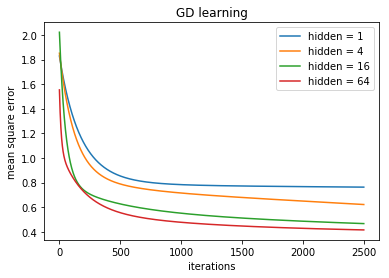

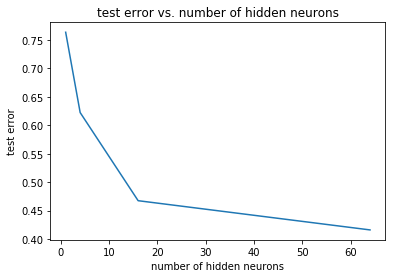

Process ForkPoolWorker-7:
Process ForkPoolWorker-6:
Process ForkPoolWorker-8:
Process ForkPoolWorker-5:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/shiganyu/anaconda3/envs/cz4042/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/shiganyu/anaconda3/envs/cz4042/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/shiganyu/anaconda3/envs/cz4042/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/shiganyu/anaconda3/envs/cz4042/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/shiganyu/anaconda3/envs/cz4042/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/shiganyu/anaconda3/envs/cz4042/lib/python3.6/multiprocessing/process.py", line

In [3]:
import numpy as np
from sklearn import datasets
from sklearn import model_selection
from sklearn import preprocessing
import tensorflow as tf
import pylab as plt
import multiprocessing as mp
import pandas

import os
if not os.path.isdir('figures'):
    print('creating the figures folder')
    os.makedirs('figures')
    
learning_rate = 0.01

no_features = 36
no_labels = 6
no_iters = 2500

seed = 10
tf.set_random_seed(seed)

train = pandas.read_csv("sat_train.txt", delimiter=' ', header=None)
test = pandas.read_csv("sat_test.txt", delimiter=' ', header=None)
x_train = train.iloc[:, :36]
print('x train:', x_train.shape)
y_train = pandas.get_dummies(train.iloc[:, 36])
print('y train: ', y_train.shape)
x_test = test.iloc[:, :36]
print('x test:', x_test.shape)
y_test = pandas.get_dummies(test.iloc[:, 36])
print('y test:', y_test.shape)

# Scale data (training set) to 0 mean and unit standard deviation.
scaler = preprocessing.StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)


def ffn(x, hidden_units):
    # Hidden
    with tf.name_scope('hidden'):
        weights = tf.Variable(
            tf.truncated_normal([no_features, hidden_units],
                                stddev=1.0 / np.sqrt(float(no_features))),
            name='weights')
        biases = tf.Variable(tf.zeros([hidden_units]),
                             name='biases')
        hidden = tf.nn.sigmoid(tf.matmul(x, weights) + biases)

    # Linear
    with tf.name_scope('softmax'):
        weights = tf.Variable(
            tf.truncated_normal([hidden_units, no_labels],
                                stddev=1.0 / np.sqrt(float(hidden_units))),
            name='weights')
        biases = tf.Variable(tf.zeros([no_labels]),
                             name='biases')
        u = tf.matmul(hidden, weights) + biases
        p = tf.exp(u) / tf.reduce_sum(tf.exp(u), axis=1, keepdims=True)
        y = tf.argmax(p, axis=1)

    return u


def my_train(hidden_units):
    x = tf.placeholder(tf.float32, [None, no_features])

    # Define loss and optimizer
    y_ = tf.placeholder(tf.float32, [None, no_labels])

    # Build the graph for the deep net
    y = ffn(x, hidden_units)

    error = tf.reduce_mean(tf.reduce_sum(tf.square(y - y_), axis=1))
    #   error = tf.reduce_sum(tf.cast(tf.not_equal(tf.argmax(y_, 1), y), tf.float64))

    train = tf.train.GradientDescentOptimizer(learning_rate).minimize(error)

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())

        te_err = []
        for i in range(no_iters):
            train.run(feed_dict={x: x_train, y_: y_train})

            te_err.append(error.eval(feed_dict={x: x_test, y_: y_test}))

            if i % 100 == 0:
                print('%d: step %d, test error %g' % (hidden_units, i, te_err[i]))

    return te_err


def main():
    hidden_units = [1, 4, 16, 64]
    no_threads = mp.cpu_count()


    p = mp.Pool(processes=no_threads)
    cost = p.map(my_train, hidden_units)

    # plot learning curves
    plt.figure(1)

    min_cost = []
    for h in range(len(hidden_units)):
        plt.plot(range(no_iters), cost[h], label='hidden = {}'.format(hidden_units[h]))
        min_cost.append(min(cost[h]))

    plt.xlabel('iterations')
    plt.ylabel('mean square error')
    plt.title('GD learning')
    plt.legend()
    plt.savefig('figures/5.3b_1.png')

    plt.figure(2)
    plt.plot(hidden_units, min_cost)
    plt.xlabel('number of hidden neurons')
    plt.ylabel('test error')
    plt.title('test error vs. number of hidden neurons')
    plt.savefig('figures/5.3b_2.png')
    
    plt.show()

if __name__ == '__main__':
    main()



In [16]:
#
# Chapter 6, example 4a
#

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import math

import tensorflow as tf
import numpy as np
import pylab as plt
import pandas as pd

# The MNIST dataset has 10 classes, representing the digits 0 through 9.
NUM_CLASSES = 6
NUM_FEATURES = 36
seed = 10
learning_rate = 0.01
no_epochs = 1000
batch_size = 32
beta = 10**(-6)

hidden1_units = 10

tf.logging.set_verbosity(tf.logging.ERROR)
tf.set_random_seed(seed)
np.random.seed(seed)

import os

if not os.path.isdir('figures'):
    print('creating the figures folder')
    os.makedirs('figures')


def main():
    # Import data

    train = pd.read_csv("sat_train.txt", delimiter=' ', header=None)
    test = pd.read_csv("sat_test.txt", delimiter=' ', header=None)
    trainX = train.iloc[:, :36]
    print('x train:', trainX.shape)
    trainY = pd.get_dummies(train.iloc[:, 36])
    print('y train: ', trainY.shape)
    testX = test.iloc[:, :36]
    print('x test:', testX.shape)
    testY = pd.get_dummies(test.iloc[:, 36])
    print('y test:', testY.shape)

    # Create the model


    x = tf.placeholder(tf.float32, [None, NUM_FEATURES])

    # Define loss and optimizer
    y_ = tf.placeholder(tf.float32, [None, NUM_CLASSES])

    # Build the graph for the deep net
    w1 = tf.Variable(
        tf.truncated_normal([NUM_FEATURES, hidden1_units],
                            stddev=1.0 / math.sqrt(float(NUM_FEATURES))),name='weights')
    b1 = tf.Variable(tf.zeros([hidden1_units]), name='biases')
    h1 = tf.nn.relu(tf.matmul(x, w1) + b1)

    w2 = tf.Variable(
        tf.truncated_normal([hidden1_units, NUM_CLASSES],
                            stddev=1.0 / math.sqrt(float(hidden1_units))),name='weights')
    b2 = tf.Variable(tf.zeros([NUM_CLASSES]), name='biases')
    y = tf.matmul(h1, w2) + b2

    with tf.name_scope('cross_entropy'):
        cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(
            labels=y_, logits=y)

    regularization = tf.nn.l2_loss(w1) + tf.nn.l2_loss(w2)

    loss = tf.reduce_mean(cross_entropy + beta * regularization)

    # Add a scalar summary for the snapshot loss.
    # Create the gradient descent optimizer with the given learning rate.
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    # Create a variable to track the global step.
    global_step = tf.Variable(0, name='global_step', trainable=False)
    # Use the optimizer to apply the gradients that minimize the loss
    # (and also increment the global step counter) as a single training step.
    train_op = optimizer.minimize(loss, global_step=global_step)

    with tf.name_scope('accuracy'):
        correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
        correct_prediction = tf.cast(correct_prediction, tf.float32)
        accuracy = tf.reduce_mean(correct_prediction)

    N = len(trainX)
    idx = np.arange(N)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())

        test_acc = []
        for i in range(no_epochs):
            np.random.shuffle(idx)
            from sklearn.utils import shuffle
            trainX = shuffle(trainX)
            trainY = shuffle(trainY)

            for start, end in zip(range(0, N, batch_size), range(batch_size, N, batch_size)):
                train_op.run(feed_dict={x: trainX[start:end], y_: trainY[start:end]})

            test_acc.append(accuracy.eval(feed_dict={x: testX, y_: testY}))
            if i % 100 == 0:
                print('iter %d: test accuracy %g' % (i, test_acc[i]))

    plt.figure(1)
    plt.plot(range(no_epochs), test_acc)
    plt.xlabel('epochs')
    plt.ylabel('test accuracy')
    plt.savefig('./figures/6.4a_1.png')

    plt.show()


if __name__ == '__main__':
    main()


x train: (4435, 36)
y train:  (4435, 6)
x test: (2000, 36)
y test: (2000, 6)
iter 0: test accuracy 0.2305
iter 100: test accuracy 0.2305
iter 200: test accuracy 0.2305
iter 300: test accuracy 0.2305
iter 400: test accuracy 0.2305
iter 500: test accuracy 0.2305
iter 600: test accuracy 0.2305
iter 700: test accuracy 0.2305


KeyboardInterrupt: 